# 基于信用卡消费行为的客户违约分析


## 获取实验数据集并进行缺失值和异常值统计 （参考代码）


In [1]:
# 导入pandas包
import pandas as pd

# 数据文件路径
datafile = './data/cs-training.csv'

# 读取文件到dataframe - data
data = pd.read_csv(datafile, index_col=[0])

# 对列进行统计并进行转置
data_statistics = data.describe().T

# 计算空值记录数量
data_statistics['null'] = len(data) - data_statistics['count']

# 只选取统计结果中的count, null, max, min
data_statistics = data_statistics[['count', 'null', 'max', 'min']]

# 重命名列名
data_statistics.columns = ['总样本数', '空值数量', '最大值', '最小值']

In [2]:
data_statistics

,总样本数,空值数量,最大值,最小值
SeriousDlqin2yrs,1000.0,0.0,1.0,0.0
RevolvingUtilizationOfUnsecuredLines,1000.0,0.0,2340.0,0.0
age,1000.0,0.0,97.0,22.0
NumberOfTime30-59DaysPastDueNotWorse,1000.0,0.0,98.0,0.0
DebtRatio,1000.0,0.0,15466.0,0.0
MonthlyIncome,819.0,181.0,208333.0,0.0
NumberOfOpenCreditLinesAndLoans,1000.0,0.0,31.0,0.0
NumberOfTimes90DaysLate,1000.0,0.0,98.0,0.0
NumberRealEstateLoansOrLines,1000.0,0.0,8.0,0.0
NumberOfTime60-89DaysPastDueNotWorse,1000.0,0.0,98.0,0.0


## 1.编写代码绘制客户年龄直方图和客户月收入直方图


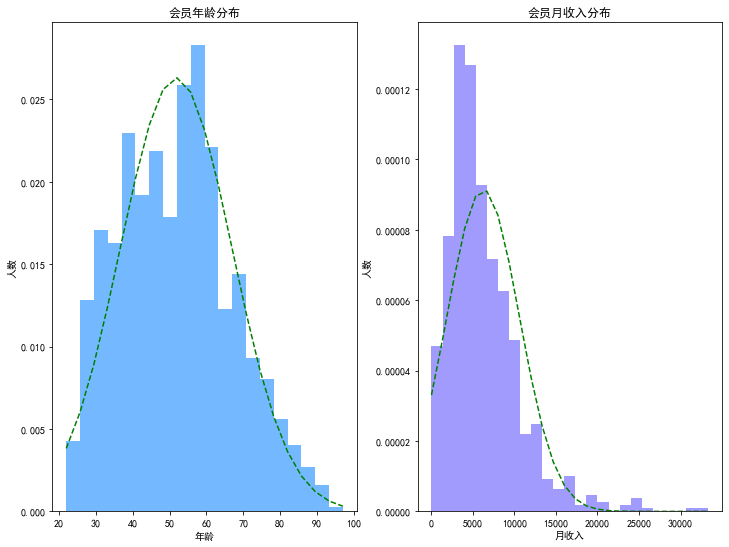

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm


#  Jupyter 内置绘图
%matplotlib inline

# 设置中文
plt.rcParams['font.sans-serif'] = ['SimHei']

# 取出数据
customeAges = data['age']
customeMonthlyIncome = data['MonthlyIncome']

# 子图绘制
fig = plt.figure(figsize = (12, 9))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# 会员年龄分布
n, bin, patches = ax1.hist(customeAges, 
bins=20, 
label='直方图',
color= '#74b9ff',
density=True
)

# 均值
mu = np.mean(customeAges)

# 标准差
sigma = np.std(customeAges)

# 拟合直方图曲线
y = norm.pdf(bin, mu, sigma)

# 绘制曲线
ax1.plot(bin, y, 'g--')
ax1.set(xlabel='年龄', ylabel='人数', title='会员年龄分布')

# 会员月收入分布
customeMonthlyIncome = [i for i in customeMonthlyIncome if i < 35000]

n, bin, patches = ax2.hist(customeMonthlyIncome, 
bins=25, 
label='直方图',
color='#a29bfe',
density=True
)

# 均值
mu = np.mean(customeMonthlyIncome)

# 标准差
sigma = np.std(customeMonthlyIncome)

# 拟合直方图曲线
y = norm.pdf(bin, mu, sigma)

# 绘制曲线
ax2.plot(bin, y, 'g--')

ax2.set(xlabel='月收入', ylabel='人数', title='会员月收入分布')


plt.show()

## 2.处理缺失值


In [4]:
from sklearn.ensemble import RandomForestClassifier

# 提取特征值
process_df = data.iloc[:, [5, 0, 1, 2, 3, 4, 6, 7, 8, 9]]

# 分成已知该特征和未知该特征两部分
# 已知特征值
known = process_df[process_df.MonthlyIncome.notnull()].values
# 未知特征值
unknown = process_df[process_df.MonthlyIncome.isnull()].values

#X为特征属性值
X = known[:, 1:]

#y为结果标签值
y = known[:, 0]

#建立RandomForestClassifier模型
RFC = RandomForestClassifier(random_state=0,
                             n_estimators=200,
                             max_depth=3,
                             n_jobs=-1)
RFC.fit(X, y)

#用得到的模型进行未知特征值预测
predicted = RFC.predict(unknown[:, 1:]).round(0)

#用得到的预测结果填补原缺失数据
data.loc[(data.MonthlyIncome.isnull()), 'MonthlyIncome'] = predicted

#删除含有缺失值的记录
data = data.dropna()

#删除重复记录
data = data.drop_duplicates()

#产生多个列的汇总统计，T表示转置
data_statistics = data.describe().T

#计算空值记录数
data_statistics['null'] = len(data) - data_statistics['count']

#只选取统计结果中的'count'，'null','max','min'四列的内容
data_statistics = data_statistics[['count', 'null', 'max', 'min']]

#重命名列
data_statistics.columns = ['总样本数', '空值数', '最大值', '最小值']

print(data_statistics)

#缺失值处理结果输出到文件
data.to_csv('MissingData.csv', index=False)


                                       总样本数  空值数       最大值   最小值
SeriousDlqin2yrs                      967.0  0.0       1.0   0.0
RevolvingUtilizationOfUnsecuredLines  967.0  0.0    2340.0   0.0
age                                   967.0  0.0      92.0  22.0
NumberOfTime30-59DaysPastDueNotWorse  967.0  0.0      98.0   0.0
DebtRatio                             967.0  0.0   15466.0   0.0
MonthlyIncome                         967.0  0.0  208333.0   0.0
NumberOfOpenCreditLinesAndLoans       967.0  0.0      31.0   0.0
NumberOfTimes90DaysLate               967.0  0.0      98.0   0.0
NumberRealEstateLoansOrLines          967.0  0.0       8.0   0.0
NumberOfTime60-89DaysPastDueNotWorse  967.0  0.0      98.0   0.0
NumberOfDependents                    967.0  0.0       6.0   0.0


在0.20.0开始，.ix索引器已被弃用，赞成更加严格的 .iloc 和.loc索引 来进行用下标的引用

as_matrix 已经被启用, 更加赞成使用 values

因为删除了33个样本，所以记录中只有967个样本，除了利用随机森林算法进行缺失值填充

**还有其他哪些方法能够进行缺失值填充，请同学自行编写相关代码**

In [5]:
from sklearn.impute import SimpleImputer

# 列平均值补充缺失值
imp_mean = SimpleImputer(strategy='mean')

# 提取特征值
process_df = data.iloc[:, [5, 0, 1, 2, 3, 4, 6, 7, 8, 9]]

df = pd.DataFrame(imp_mean.fit_transform(process_df))

#产生多个列的汇总统计，T表示转置
data_statistics = df.describe().T

#计算空值记录数
data_statistics['null'] = len(data) - data_statistics['count']

#只选取统计结果中的'count'，'null','max','min'四列的内容
data_statistics = data_statistics[['count', 'null', 'max', 'min']]

#重命名列
data_statistics.columns = ['总样本数', '空值数', '最大值', '最小值']

print(data_statistics)

    总样本数  空值数       最大值   最小值
0  967.0  0.0  208333.0   0.0
1  967.0  0.0       1.0   0.0
2  967.0  0.0    2340.0   0.0
3  967.0  0.0      92.0  22.0
4  967.0  0.0      98.0   0.0
5  967.0  0.0   15466.0   0.0
6  967.0  0.0      31.0   0.0
7  967.0  0.0      98.0   0.0
8  967.0  0.0       8.0   0.0
9  967.0  0.0      98.0   0.0


## 3. 处理异常值


### 3.1 单变量离群值检测

In [56]:
#异常值处理
data1 = pd.read_csv('MissingData.csv')

# 异常值所在的行
lst = []

# 异常值 - 月收入为0的行, 年龄大于100或者小于0的行
lst = lst + data1[data1['MonthlyIncome'] <= 0].index.tolist()
lst = lst + data1[data1['age'] <= 0].index.tolist()
lst = lst + data1[data1['age'] >= 100].index.tolist()

#删除异常值所在的行
DeleteAbnormalData = data1.drop(lst)

#产生多个列的汇总统计
data2_statistics=DeleteAbnormalData.describe(include='all').T

#计算空值记录数
data2_statistics['null'] = len(DeleteAbnormalData)-data2_statistics['count']

#只选取统计结果中的'count'，'null','max','min'四列的内容
data2_statistics = data2_statistics[['count','null','max','min']]

#重命名列
data2_statistics.columns=['总样本数','空值数','最大值','最小值'] 

print(data2_statistics)

#异常值处理结果输出到文件
DeleteAbnormalData.to_csv('DeleteAbnormalData.csv',index=False)
DeleteAbnormalData.to_csv('AbnormalData.csv',index=False)

                                       总样本数  空值数       最大值   最小值
SeriousDlqin2yrs                      809.0  0.0       1.0   0.0
RevolvingUtilizationOfUnsecuredLines  809.0  0.0    2340.0   0.0
age                                   809.0  0.0      92.0  22.0
NumberOfTime30-59DaysPastDueNotWorse  809.0  0.0      98.0   0.0
DebtRatio                             809.0  0.0    2221.5   0.0
MonthlyIncome                         809.0  0.0  208333.0   1.0
NumberOfOpenCreditLinesAndLoans       809.0  0.0      31.0   0.0
NumberOfTimes90DaysLate               809.0  0.0      98.0   0.0
NumberRealEstateLoansOrLines          809.0  0.0       8.0   0.0
NumberOfTime60-89DaysPastDueNotWorse  809.0  0.0      98.0   0.0
NumberOfDependents                    809.0  0.0       6.0   0.0


### 3.2 局部离群值因子检测

In [96]:
from sklearn.neighbors import LocalOutlierFactor

data_lof = pd.read_csv('MissingData.csv')
data_lof['MonthlyIncome']

# 异常值所在的行
clf = LocalOutlierFactor(n_neighbors=4)

# 查询结果
condition = clf.fit_predict([[i] for i in list(data_lof['MonthlyIncome'].values)])

# 离群值所在索引
toDrop = []
index = 0
for i in condition:
  if i == -1:
    toDrop.append(index)
  index += 1

#删除异常值所在的行
DeleteAbnormalData = data_lof.drop(toDrop)

#产生多个列的汇总统计
data_lof_statistics = DeleteAbnormalData.describe(include='all').T

data_lof_statistics


,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,829.0,0.056695,0.231398,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,829.0,5.622894,108.335686,0.0,0.032618,0.155742,0.526202,2340.0
age,829.0,51.663450,15.047393,22.0,40.000000,52.000000,62.000000,92.0
NumberOfTime30-59DaysPastDueNotWorse,829.0,0.386007,3.482267,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,829.0,387.820438,1239.147516,0.0,0.166215,0.355044,0.802982,15466.0
MonthlyIncome,829.0,5032.024125,4496.407508,0.0,1886.000000,4200.000000,7500.000000,26484.0
NumberOfOpenCreditLinesAndLoans,829.0,8.615199,5.222842,0.0,5.000000,8.000000,11.000000,31.0
NumberOfTimes90DaysLate,829.0,0.311218,4.771811,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,829.0,0.962606,1.019046,0.0,0.000000,1.000000,2.000000,8.0
NumberOfTime60-89DaysPastDueNotWorse,829.0,0.291918,4.768981,0.0,0.000000,0.000000,0.000000,98.0


### 3.3基于聚类方法的离群值检测

In [189]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# 读取数据
data_cluster = pd.read_csv('MissingData.csv')

# 聚簇个数
n_clusters = 8

# 创建模型, 并预测每一个样本所属的聚类索引
model = KMeans(n_clusters = n_clusters)
cluster_labels = model.fit_predict([[i] for i in list(data_cluster['MonthlyIncome'].values)])
r = pd.concat([data_cluster['MonthlyIncome'],pd.Series(model.labels_, index=data_cluster['MonthlyIncome'].index)], axis = 1)

# 打分, 分值为 norm
norm = []
for i in range(n_clusters):
  norm_tmp = r[['MonthlyIncome']][r[0] == i] - model.cluster_centers_[i]
  norm_tmp = norm_tmp.apply(np.linalg.norm, axis = 1)
  norm_tmp = norm_tmp / norm_tmp.median()
  norm.extend(norm_tmp)

# 转换为np类型
norm = np.array(norm)

# 把离聚簇中心最远的点删去
toDrop = []
index = 0
for i in list(norm):
  if i >= 1.8:
    toDrop.append(index)
  index += 1

#删除异常值所在的行
DeleteAbnormalData = data_cluster.drop(toDrop)

#产生多个列的汇总统计
data_cluster_statistics = DeleteAbnormalData.describe(include='all').T

data_cluster_statistics

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,834.0,0.061151,0.239751,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,834.0,5.596607,108.010591,0.0,0.033841,0.161152,0.538144,2340.0
age,834.0,51.607914,14.816476,22.0,40.000000,52.000000,62.000000,92.0
NumberOfTime30-59DaysPastDueNotWorse,834.0,0.496403,4.800771,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,834.0,306.828048,1019.228938,0.0,0.166469,0.351479,0.670374,11311.0
MonthlyIncome,834.0,5496.510791,5463.909254,0.0,2400.000000,4500.000000,7691.750000,70000.0
NumberOfOpenCreditLinesAndLoans,834.0,8.703837,5.100414,0.0,5.000000,8.000000,11.000000,31.0
NumberOfTimes90DaysLate,834.0,0.318945,4.758156,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,834.0,0.984412,1.002277,0.0,0.000000,1.000000,2.000000,8.0
NumberOfTime60-89DaysPastDueNotWorse,834.0,0.175060,3.336732,0.0,0.000000,0.000000,0.000000,96.0


## 4. 数据特征分析

数据特征分析主要分析各变量对输出结果的影响，在本项目中，主要关注的是违约客户与各变量间的关系。首先来观察是否超过90天还款的SeriousDlqin2yrs客户的整体情况，数据集中好客户（不超过还款期）为0，违约客户（超过还款期）为1。

违约客户占比：5.93%


<AxesSubplot:xlabel='SeriousDlqin2yrs'>

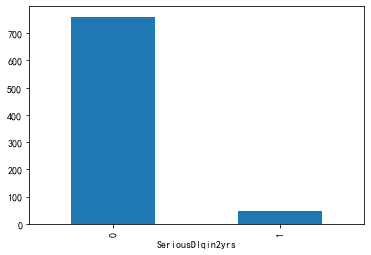

In [7]:
import pandas as pd

#读取异常处理后的数据集
data5 = pd.read_csv('DeleteAbnormalData.csv')   

grouped=data5['SeriousDlqin2yrs'].groupby(data5['SeriousDlqin2yrs']).count()

print('违约客户占比：%.2f%%'%(100*grouped[1]/(grouped[0]+grouped[1])))

#显示SeriousDlqin2yrs客户的整体情况如下图所示
grouped.plot(kind='bar')  

下面给出年龄与违约客户数的变化关系图（编写可视化代码），由下图可知知22岁至42岁之间随着年龄的增长，违约客户数在增加，这可能是这个年龄段花费比较多而本身的支付能力有限所导致；此后随着年龄增长，违约客户数在递减，这可能随着年龄的增长客户收入增加了、消费趋于理性了。

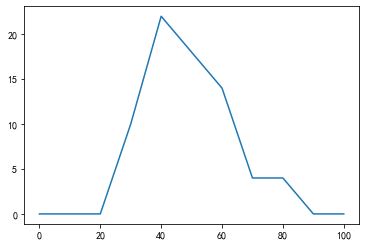

In [8]:
sorted_dict = data5['age'].groupby(data5['age']).count().to_dict()

for i in range(101):
  if sorted_dict.__contains__(i) == False:
    sorted_dict[i] = 0

lst = list(sorted_dict.items())
lst.sort(key=lambda x:x[0])

# lst 为 0-100岁的用户的年龄的数据
lst = [i[1] for i in lst]


plt.plot([i for i in range(0, 101, 10)], \
         [lst[i] for i in range(0, 101, 10)])



另外还能进行多变量分析，多变量分析主要用于分析变量之间相关的程度，在pandas中可采用corr()函数计算各变量间的相关性，下面的代码用来求各变量间的相关性，其得到的变量间的相关性如下表所示。各变量间相关性较小，不存在共线性可能。

In [9]:
#重新命名列名
data5.columns = ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']

#计算各列之间的相关性
data5.corr(method='pearson')

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
x0,1.000000,0.086924,-0.060878,0.026622,-0.014532,-0.018155,0.058288,0.000429,0.068987,0.004014,0.072419
x1,0.086924,1.000000,0.000587,-0.004983,-0.003758,0.002659,-0.013532,0.001616,0.025869,-0.003001,0.032771
x2,-0.060878,0.000587,1.000000,-0.047330,0.024139,0.032870,0.163381,0.014254,0.000484,-0.009522,-0.167314
x3,0.026622,-0.004983,-0.047330,1.000000,-0.007687,-0.013343,-0.037991,0.001989,-0.029476,0.004071,-0.000349
x4,-0.014532,-0.003758,0.024139,-0.007687,1.000000,-0.056229,0.078768,-0.004968,0.027086,-0.004608,-0.017760
x5,-0.018155,0.002659,0.032870,-0.013343,-0.056229,1.000000,0.129328,-0.020684,0.167150,-0.021064,0.109003
x6,0.058288,-0.013532,0.163381,-0.037991,0.078768,0.129328,1.000000,-0.037754,0.401653,0.033220,0.089713
x7,0.000429,0.001616,0.014254,0.001989,-0.004968,-0.020684,-0.037754,1.000000,-0.029490,-0.001770,-0.015030
x8,0.068987,0.025869,0.000484,-0.029476,0.027086,0.167150,0.401653,-0.029490,1.000000,-0.047227,0.123589
x9,0.004014,-0.003001,-0.009522,0.004071,-0.004608,-0.021064,0.033220,-0.001770,-0.047227,1.000000,-0.012095


除了pearson方法，利用其他多变量分析函数求各变量间的相关性。除了上述结论，通过cs-training.csv中的数据，还能得到其他哪些结论，利用数据可视化，在实验报告中进行说明。

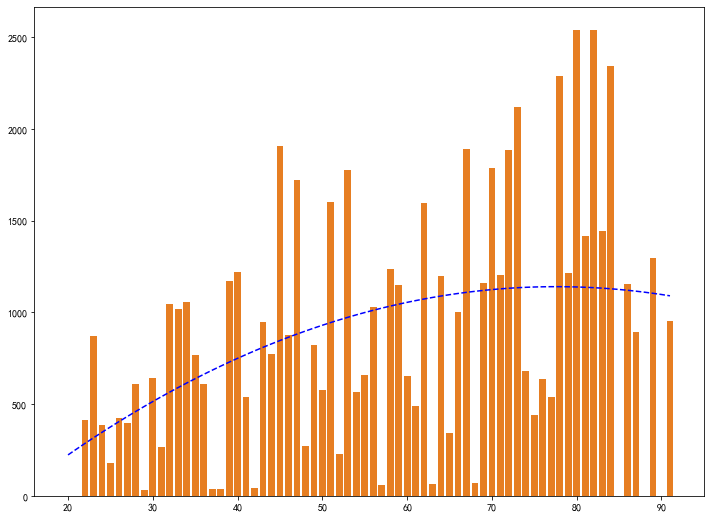

In [10]:
import pandas as pd

# 读取异常处理后的数据集
data5 = pd.read_csv('DeleteAbnormalData.csv')   

# 年龄和收入
ageAndIncome = data5.iloc[:, [2, 5]]

# 按照年龄排序
sortedData = ageAndIncome.sort_values(by=['age'])

# x 轴的数据
x = range(20, 92)
y = {}

# y 轴的数据
for i in range(20, 92):
  if sortedData[sortedData['age'] == i].size == 0:
    y[i] = 0
  else:
    y[i] = np.median(sortedData[sortedData['age'] == i])

fig, ax = plt.subplots(figsize=(12, 9))

ax.bar(y.keys(), y.values(), color='#e67e22')

# 线性拟合年龄收入曲线
bin = [i for i in range(20, 92)]
coeff = np.polyfit(bin, list(y.values()), 2)
ax.plot(bin, coeff[0] * x * x + coeff[1] * x + coeff[2], 'b--')

plt.show()


## 5. 客户违约分析

当数据预处理完成后，我们需要选择有意义的特征来构建数据分析模型，好的特征能够构造出较好的分析模型。特征选择主要有两个目的：

一是减少特征数量、降维，使模型泛化能力更强，减少过拟合；

二是增强对特征和特征值之间的理解。
  
  客户有10个属性，也就是说10个变量决定了客户违约情况，这就需要计算这些变量和客户违约情况的相关性。

In [11]:
data6 = pd.read_csv('DeleteAbnormalData.csv')

#重新命名列
data6.columns = ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10'] 

#获取客户的10个属性和违约情况的相关性如下表所示
#x0指代SeriousDlqin2yrs  
data6.corr().sort_values(by=['x0'],ascending=False) 

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
x0,1.000000,0.086924,-0.060878,0.026622,-0.014532,-0.018155,0.058288,0.000429,0.068987,0.004014,0.072419
x1,0.086924,1.000000,0.000587,-0.004983,-0.003758,0.002659,-0.013532,0.001616,0.025869,-0.003001,0.032771
x10,0.072419,0.032771,-0.167314,-0.000349,-0.017760,0.109003,0.089713,-0.015030,0.123589,-0.012095,1.000000
x8,0.068987,0.025869,0.000484,-0.029476,0.027086,0.167150,0.401653,-0.029490,1.000000,-0.047227,0.123589
x6,0.058288,-0.013532,0.163381,-0.037991,0.078768,0.129328,1.000000,-0.037754,0.401653,0.033220,0.089713
x3,0.026622,-0.004983,-0.047330,1.000000,-0.007687,-0.013343,-0.037991,0.001989,-0.029476,0.004071,-0.000349
x9,0.004014,-0.003001,-0.009522,0.004071,-0.004608,-0.021064,0.033220,-0.001770,-0.047227,1.000000,-0.012095
x7,0.000429,0.001616,0.014254,0.001989,-0.004968,-0.020684,-0.037754,1.000000,-0.029490,-0.001770,-0.015030
x4,-0.014532,-0.003758,0.024139,-0.007687,1.000000,-0.056229,0.078768,-0.004968,0.027086,-0.004608,-0.017760
x5,-0.018155,0.002659,0.032870,-0.013343,-0.056229,1.000000,0.129328,-0.020684,0.167150,-0.021064,0.109003


我们定义和SeriousDlqin2yrs之间的相关性低于0.07的特征为预测能力较弱或无关特征，表中可以看到x8、x6、x4、x5、x2这五个属性与x0的相关性均低于0.07，因此将age、DebtRatio、MonthlyIncome、NumberOfOpenCreditLinesAndLoans、NumberRealEstateLoansOrLines等五个属性删除。下面通过逻辑回归分析预测客户是否违约。

In [202]:
#逻辑回归分析
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn import metrics

data7 = pd.read_csv('DeleteAbnormalData.csv')
data8 = data7[['SeriousDlqin2yrs','RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']]
Y=data8['SeriousDlqin2yrs']
X=data8.iloc[:,1:]

#为了验证模型的拟合效果，需要先对数据集进行切分，分成训练集和测试集
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)

#建立逻辑回归模型
lr=LR()

#训练模型
lr.fit(X_train,Y_train)      

#用得到的模型对30%的测试集进行预测
y_pred = lr.predict(X_test)  

#用均方误差来评价模型优劣
print( "模型预测的均方误差:",metrics.mean_squared_error(Y_test, y_pred))


     RevolvingUtilizationOfUnsecuredLines  \
0                                0.766127   
1                                0.957151   
2                                0.658180   
3                                0.233810   
4                                0.907239   
..                                    ...   
804                              0.037454   
805                              0.102951   
806                              1.000000   
807                              0.040283   
808                              0.352989   

     NumberOfTime30-59DaysPastDueNotWorse  NumberOfTimes90DaysLate  \
0                                       2                        0   
1                                      98                        0   
2                                      96                        1   
3                                       0                        0   
4                                       1                        0   
..                                    .

运行上述代码得到的输出结果如下：
模型预测的均方误差: 0.058091286307053944 	
从输出的模型预测的均方误差来看，说明该模型的预测效果还是很好的（预测值y_pred和真实值Y_test的误差很小），正确率较高，所以通过该模型可预测客户是否违约。

除了以上减少特征数量、降维的方法，还有哪些其他方法？同学们自行编程实现，并利用LR模型计算不同降维方法的预测均方误差。除了LR模型，再利用一种其他的机器学习模型进行预测。


In [231]:
# IPCA降维的逻辑回归分析
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn import metrics

data7 = pd.read_csv('DeleteAbnormalData.csv')

# IPCA 降维后留下4个特征
pca = KernelPCA(n_components = 4)
Y = data7['SeriousDlqin2yrs']
X = pca.fit_transform(data7)

#为了验证模型的拟合效果，需要先对数据集进行切分，分成训练集和测试集
X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=0.3, random_state=0)

#建立\训练\测试
lr=LR()
lr.fit(X_train,Y_train)      
y_pred = lr.predict(X_test)  

#用均方误差来评价模型优劣
print( "模型预测的均方误差:",metrics.mean_squared_error(Y_test, y_pred))

模型预测的均方误差: 0.05761316872427984


In [213]:
# PCA降维的逻辑回归分析

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn import metrics
import numpy as np

data7 = pd.read_csv('DeleteAbnormalData.csv')

# PCA 降维后留下4个特征
pca = PCA(n_components = 4)
Y = data7['SeriousDlqin2yrs']
X = pca.fit_transform(data7)

# print(X)

#为了验证模型的拟合效果，需要先对数据集进行切分，分成训练集和测试集
X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=0.3, random_state=0)

#建立\训练\测试
lr=LR()
lr.fit(X_train,Y_train)      
y_pred = lr.predict(X_test)  

#用均方误差来评价模型优劣
print( "模型预测的均方误差:",metrics.mean_squared_error(Y_test, y_pred))


模型预测的均方误差: 0.05761316872427984


In [10]:
# SVM + PCA

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

data7 = pd.read_csv('DeleteAbnormalData.csv')

# PCA 降维后留下4个特征
pca = PCA(n_components = 4)
Y = data7['SeriousDlqin2yrs']
X = pca.fit_transform(data7)

#为了验证模型的拟合效果，需要先对数据集进行切分，分成训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

#建立\训练\测试
svm = svm.SVC()
svm.fit(X_train,Y_train)      
y_pred = svm.predict(X_test)  

#用均方误差来评价模型优劣
print( "模型预测的均方误差:",metrics.mean_squared_error(Y_test, y_pred))


模型预测的均方误差: 0.06172839506172839


简述题：谈谈对数据中特征降维的理解？当数据维数较大时，对其降维有什么好处？Sklearn库中有哪些自带降维函数？